### 데이터 불러오기

In [1]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [102]:
import pandas as pd

train_df = pd.read_csv('./nsmc/ratings_train.txt', sep='\t')
test_df = pd.read_csv('./nsmc/ratings_test.txt', sep='\t')
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

### 데이터 정제

In [3]:
import nltk
nltk.download('all',quiet = True)

True

In [103]:
from nltk.tokenize import word_tokenize

train_text = []
test_text = []

for text in train_df['document'][:8000]:
  train_text.append(word_tokenize(text))
for text in test_df['document'][8000:9000]:
  test_text.append(word_tokenize(text))

train_label = train_df['label'][:8000]
test_label = test_df['label'][8000:9000]

# 인덱스 헷갈려서 새로 저장
train_df = train_df[:8000]
test_df = test_df[8000:9000]

test_df.reset_index(drop = True,inplace = True)
test_label.reset_index(drop = True,inplace = True)

In [44]:
train_text[:5]

[['아', '더빙..', '진짜', '짜증나네요', '목소리'],
 ['흠', '...', '포스터보고', '초딩영화줄', '...', '.오버연기조차', '가볍지', '않구나'],
 ['너무재밓었다그래서보는것을추천한다'],
 ['교도소', '이야기구먼', '..솔직히', '재미는', '없다..평점', '조정'],
 ['사이몬페그의',
  '익살스런',
  '연기가',
  '돋보였던',
  '영화',
  '!',
  '스파이더맨에서',
  '늙어보이기만',
  '했던',
  '커스틴',
  '던스트가',
  '너무나도',
  '이뻐보였다']]

 > ***문제점***
   
 ---
1. 한글 이외의 문자는 (구두점, 숫자, 영어 등) 제거하는 것이 합리적 
- 정규표현식을 사용하여 간단히 제거할 수 있다.
---
2. '너무재밓었다그래서보는것을추천한다' 와 같이 맞춤법이 틀리거나 띄워쓰기가 제대로 되어 있지 않은 것을 확인!
3. 'ㅋㅋㅋㅋㅋㅋㅋ' 처럼 반복되는 자모는 축약할 필요가 있음
- word_tokenize로는 토큰화가 제대로 이뤄지지 않은 것을 확인할 수 있었다. py-hanspell 패키지를 사용해 일부 오타 및 띄워쓰기 교정,soynlp 패캐지를 사용해 정규화를 수행한 이후, Okt 패키지를 사용해 토큰화를 진행하여 어간을 추출하기로 하였다.
---

#### 1. 데이터 정제 - 한글이 아닌 것 (영어, 숫자, 구두점 등) 제거

In [46]:
import numpy as np

In [96]:
# 원본 데이터는 남겨둠
train = train_df.copy()
test = test_df.copy()

In [104]:
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
train_df['document'] = train_df['document'].str.replace(" +"," ")

test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
test_df['document'] = test_df['document'].str.replace(" +"," ")

In [120]:
test.document[test_df.document == ' ']

42                     asd
72                       ♥
94                      ok
147                   shit
424                   bad!
555            12345678910
672                    2.5
761                      .
889    !!!!!!!!!!!!!!!!!!!
Name: document, dtype: object

#### 2. 데이터 정제 - 맞춤법, 띄워쓰기 교정

In [14]:
!pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-khqpetwd
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-khqpetwd
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=8b9979511f6d3c4f31365d0a12dc2466f2825de4184790ec6ebbe1f7cf7471b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-s4hbd10m/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


수행시간을 단축하기 위해 특정 길이 이상의 토큰에 대해서만 스펠링 체크 및 교정을 진행하였다.

In [53]:
def no_spacing(sent_list):

  error_list = []
  
  for i in range(len(sent_list)):
    sent = sent_list[i]
    for j in range(len(sent)):
      if len(sent[j]) > 7:
        error_list.append(i)
  
  return list(set(error_list))

In [121]:
train_df.loc[no_spacing(train_text),'document']

2                                       너무재밓었다그래서보는것을추천한다
5                막 걸음마 뗀 세부터 초등학교 학년생인 살용영화 ㅋㅋㅋ 별반개도 아까움 
7       별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지 정말 발로해도 그것보단 ...
10                                       걍인피니트가짱이다 진짜짱이다 
11              볼때마다 눈물나서 죽겠다 년대의 향수자극 허진호는 감성절제멜로의 달인이다 
                              ...                        
7966      정신 못차렸다 돈크라이마미보고 다시생각하거나 아니면 동호 스파르타식으로 연기 가르쳐라
7967             도대체 뭘말하고자하는건지 모르겠어요 공짜로본거였는데도 시간이아까웠습니다 
7972                                        배속으로봤는데도 지루하다
7989                                    왠지 프레데터와 생각났던 작품 
7993                                         재미없음 지루함의 극치
Name: document, Length: 1560, dtype: object

In [122]:
from hanspell import spell_checker

for idx in no_spacing(train_text):
  text = train_df.loc[idx,'document']
  spelled_sent = spell_checker.check(text)
  after_check = spelled_sent.checked
  train_df.loc[idx,'document'] = after_check

In [123]:
for idx in no_spacing(test_text):
  text = test_df.loc[idx,'document']
  spelled_sent = spell_checker.check(text)
  after_check = spelled_sent.checked
  test_df.loc[idx,'document'] = after_check

#### 3. 데이터 정제 - 정규화

In [19]:
!pip install soynlp

     |████████████████████████████████| 416 kB 5.1 MB/s 


In [20]:
from soynlp.normalizer import *

In [124]:
for idx in range(8000):
  text = train_df.loc[idx,'document']
  train_df.loc[idx,'document'] = repeat_normalize(text,num_repeats = 2)
for idx in range(1000):
  text = test_df.loc[idx,'document']
  test_df.loc[idx,'document'] = repeat_normalize(text,num_repeats = 2)

### 불용어 제거 & 형태소 토큰화

In [22]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 448 kB 27.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [251]:
# 자주 쓰이는 불용어
stopwords_kr = "이라 듯 나다 어떻다 분 건 이고 서 인데 오다 돼다 되어다 다 난 라고 거 기 이나 보고 만들다 나오다 영화 보다 이다 정말 너무 진짜 이렇다 싶다 아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓 게 는 은 께 에요 이에요"
stopwords_kr = set(stopwords_kr.split(' '))

In [252]:
# 형태소 추출
from konlpy.tag import Okt

train_review = []
test_review = []

train_token = []
test_token = []

okt = Okt()

for text in train_df['document']:
  tokens = okt.morphs(text,stem = True,norm = True)
  train_okt = [token for token in tokens if not token in stopwords_kr]
  train_token.append(train_okt)
  train_okt = ' '.join(train_okt)
  train_review.append(train_okt)

for text in test_df['document']:
  tokens = okt.morphs(text,stem = True,norm = True)
  test_okt = [token for token in tokens if not token in stopwords_kr]
  test_token.append(test_okt)
  test_okt = ' '.join(test_okt)
  test_review.append(test_okt)

In [60]:
train_review.count('')

106

In [132]:
test_review.count('')

11

In [134]:
train_empty = []

for idx in range(8000):
  if train_review[idx] == '':
    train_empty.append(idx)

In [72]:
test_empty = []

for idx in range(1000):
  if test_review[idx] == '':
    test_empty.append(idx)

In [135]:
train.loc[train_empty]

,id,document,label
151,7348295,아,0
159,7781028,10점,1
272,9268003,이게 2편이 나왔어???,0
349,7917426,0점은 없나??,0
404,4221289,What is this movie for?,0
...,...,...,...
7396,6100740,이런영화 또나오길!,1
7425,6594765,다섯개,1
7461,7347891,"""""""log off"""" ost조차 없었으면 0점.""",0
7580,5350096,gg woalTek,1


In [133]:
test.loc[test_empty]

,id,document,label
42,250259,asd,0
72,7907852,♥,1
94,1427748,ok,0
147,194297,shit,0
424,2767077,bad!,0
465,7450573,붕붕,0
468,8878598,3등....////,0
555,9549183,12345678910,1
672,5236221,2.5,0
761,7117472,.,0


#### 참고: 불용어 제거를 위한 Word Cloud

In [27]:
# 워드 클라우드에서 한글 깨지는 것 방지
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [253]:
pos_review = ''
neg_review = ''

for idx in range(8000):
  if train_label[idx] == 1:
    pos_review = ' '.join([pos_review,train_review[idx]])
  if train_label[idx] == 0:
    neg_review = ' '.join([neg_review,train_review[idx]])

Text(0.5, 1.0, 'Negative Review')

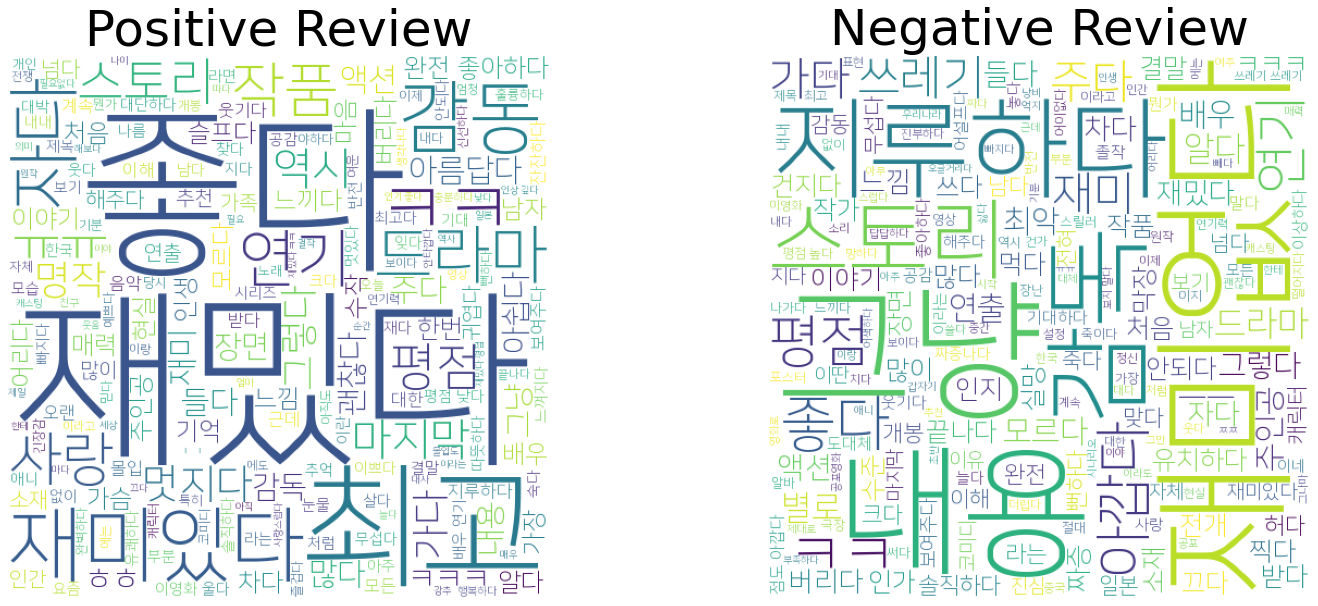

In [254]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [25,10])
wordcloud1 = WordCloud( background_color='white',
                        width = 500,
                        height = 500,
                        font_path = '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf').generate(pos_review)
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Review',fontsize = 50);

wordcloud2 = WordCloud( background_color='white',
                        width = 500,
                        height = 500,
                        font_path = '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf').generate(neg_review)
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Review',fontsize = 50)

한국어 불용어 리스트(https://www.ranks.nl/stopwords/korean) 에 워드 클라우드 결과를 추가적으로 반영하여 불용어를 제거하였습니다.

### 벡터화

#### 1. Tf-idf

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [255]:
tfidf = TfidfVectorizer(max_features = 1800,min_df = 2)

x_train = tfidf.fit_transform(train_review)
x_test = tfidf.transform(test_review)

y_train = train_label
y_test = test_label

#### 2. Word2Vec

In [151]:
from gensim.models import Word2Vec

In [292]:
sg_model = Word2Vec(sentences = train_token,size = 100,window = 5,min_count = 10,workers = 8,sg = 1,iter = 12)

In [294]:
sg_model.wv.most_similar('재미있다')

[('귀엽다', 0.9558061957359314),
 ('ㅎㅎ', 0.9525030851364136),
 ('엄청', 0.9474700689315796),
 ('기대', 0.9469557404518127),
 ('멋있다', 0.9436179399490356),
 ('즐겁다', 0.9433782696723938),
 ('예쁘다', 0.9343698620796204),
 ('재밌다', 0.9332208633422852),
 ('나름', 0.9286305904388428),
 ('대박', 0.9277386665344238)]

### 성능 평가

#### 1. Naive Bayes

In [256]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf = MultinomialNB(alpha=.01)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

print('F1 =', metrics.f1_score(y_test, pred, average='macro'))
print('accuracy =', metrics.accuracy_score(y_test, pred))

F1 = 0.7785906140453698
accuracy = 0.779


In [257]:
alpha = [0.001,0.01,0.1,0.5,0.7,0.9,1]
results = []

for a in alpha:
  clf = MultinomialNB(alpha = a)
  clf.fit(x_train, y_train)
  pred = clf.predict(x_test)
  f1 = metrics.f1_score(y_test,pred,average = 'macro')
  acc = metrics.accuracy_score(y_test, pred)
  results.append((a,f1,acc))

results = pd.DataFrame(results)
results.columns = ['alpha','F1-score','Accuracy']
results.sort_values(by = ['Accuracy'],ascending = False,axis = 0,inplace = True)

results

,alpha,F1-score,Accuracy
3,0.500,0.790411,0.791
4,0.700,0.790319,0.791
5,0.900,0.790366,0.791
6,1.000,0.790366,0.791
2,0.100,0.781497,0.782
0,0.001,0.778591,0.779
1,0.010,0.778591,0.779


#### 2. LSTM


In [149]:
import random
import os

In [150]:
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)

In [152]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [295]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_token)
vocab_size = len(tokenizer.word_index) + 1 # 제로패딩
print(vocab_size)

10330


In [296]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_review), maxlen = 100)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_review), maxlen = 100)

In [297]:
sg_model = Word2Vec(size = 100,window = 5,min_count = 10,workers = 8,sg = 1,iter = 12)

In [298]:
sg_model.build_vocab(train_token)

In [299]:
sg_model.train(train_token,total_examples = 8000,epochs = 128)

(4392124, 7521280)

In [300]:
embed_mat = np.zeros((vocab_size, 100))

for word, idx in tokenizer.word_index.items():
  if word in sg_model.wv:
    embed_mat[idx] = sg_model.wv[word]

print(embed_mat.shape)

(10330, 100)


In [301]:
embed_layer = Embedding(vocab_size, 100, weights=[embed_mat], input_length = 100, trainable = False)

In [307]:
model = Sequential()
model.add(embed_layer)
model.add(Dropout(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1033000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,150,377
Trainable params: 117,377
Non-trainable params: 1,033,000
_________________________________________________________________


In [308]:
model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])

In [309]:
callbacks = [ReduceLROnPlateau(monitor = 'val_loss', patience = 5, cooldown = 0),
             EarlyStopping(monitor = 'val_accuracy', min_delta = 1e-4, patience = 5)]

In [320]:
history = model.fit(x_train, y_train,
                    batch_size = 30,
                    epochs = 160,
                    validation_split = 0.2,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/160
214/214 [==============================] - 55s 259ms/step - loss: 0.2936 - accuracy: 0.8691 - val_loss: 0.5374 - val_accuracy: 0.7588
Epoch 2/160
214/214 [==============================] - 56s 260ms/step - loss: 0.2903 - accuracy: 0.8728 - val_loss: 0.5373 - val_accuracy: 0.7588
Epoch 3/160
214/214 [==============================] - 56s 260ms/step - loss: 0.2947 - accuracy: 0.8655 - val_loss: 0.5373 - val_accuracy: 0.7600
Epoch 4/160
214/214 [==============================] - 56s 261ms/step - loss: 0.2965 - accuracy: 0.8681 - val_loss: 0.5373 - val_accuracy: 0.7600
Epoch 5/160
214/214 [==============================] - 56s 262ms/step - loss: 0.2907 - accuracy: 0.8709 - val_loss: 0.5373 - val_accuracy: 0.7606
Epoch 6/160
214/214 [==============================] - 58s 270ms/step - loss: 0.2940 - accuracy: 0.8714 - val_loss: 0.5373 - val_accuracy: 0.7600
Epoch 7/160
214/214 [==============================] - 56s 260ms/step - loss: 0.2935 - accuracy: 0.8717 - val_loss: 0.5373 -

In [321]:
score = model.evaluate(x_test, y_test)
print()
print("LSTM 정확도:",score[1])

32/32 [==============================] - 1s 35ms/step - loss: 0.5302 - accuracy: 0.7650

LSTM 정확도: 0.7649999856948853
